**Introduction**

This will be a short exploratory analysis with the goal of becoming more familiar with the 2018 Data Science Bowl dataset and identifying some possible hurdles that could have a negative effect on model performance.

**Contents:**
- Importing and processing image data
- Looking at the image metadata summary statistics
- Plotting image width, height and area distributions
- Plotting number of nuclei per image distribution
- Plotting images with the most and fewest nuclei
- Plotting the smallest and largest nuclei

In [2]:
import os
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# sys.stdout.flush()
# These lists will be used to store the images.
imgs = []
masks = []

# These lists will be used to store the image metadata that will then be used to create
# pandas dataframes.
img_data = []
mask_data = []
print('Processing images ... ')

# Loop over the training images. tqdm is used to display progress as reading
# all the images can take about 1 - 2 minutes.
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    
    # Get image.
    imgs.append(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_area = img_width * img_height

    # Initialize counter. There is one mask for each annotated nucleus.
    nucleus_count = 1
    
    # Loop over the mask ids, read the images and gather metadata from them.
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask = imread(path + '/masks/' + mask_file)
        masks.append(mask)
        mask_height = mask.shape[0]
        mask_width = mask.shape[1]
        mask_area = mask_width * img_height
        
        # Sum and divide by 255 to get the number
        # of pixels for the nucleus. Masks are grayscale.
        nucleus_area = (np.sum(mask) / 255)
        
        mask_to_img_ratio = nucleus_area / mask_area
        
        # Append to masks data list that will be used to create a pandas dataframe.
        mask_data.append([n, mask_height, mask_width, mask_area, nucleus_area, mask_to_img_ratio])
        
        # Increment nucleus count.
        nucleus_count = nucleus_count + 1
    
    # Build image info list that will be used to create dataframe. This is done after the masks loop
    # because we want to store the number of nuclei per image in the img_data list.
    img_data.append([img_height, img_width, img_area, nucleus_count])

Processing images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:59<00:00,  5.61it/s]


**Create Images Metadata Dataframe**

Create a pandas data frame from the list of image metadata that was created in the loop above. This will make the data easier to manipulate and plot.

After creating the data frame we can take a look at its summary stats along with the first five and last five rows to make sure it looks ok and get familiar with it.

In [5]:
# Create dataframe for images
df_img = pd.DataFrame(img_data, columns=['height', 'width', 'area', 'nuclei'])

In [6]:
df_img.describe()

,height,width,area,nuclei
count,670.000000,670.000000,6.700000e+02,670.000000
mean,333.991045,378.500000,1.547583e+05,44.971642
std,149.474845,204.838693,1.908250e+05,47.962530
min,256.000000,256.000000,6.553600e+04,2.000000
25%,256.000000,256.000000,6.553600e+04,16.250000
50%,256.000000,320.000000,8.192000e+04,28.000000
75%,360.000000,360.000000,1.296000e+05,55.000000
max,1040.000000,1388.000000,1.443520e+06,376.000000


In [7]:
df_img.head()

,height,width,area,nuclei
0,256,256,65536,28
1,256,256,65536,37
2,256,320,81920,71
3,256,320,81920,87
4,256,320,81920,8


In [8]:
df_img.tail()

,height,width,area,nuclei
665,256,256,65536,14
666,256,256,65536,39
667,520,696,361920,20
668,256,256,65536,14
669,360,360,129600,25


**Create Image Masks Metadata Dataframe**

Let's create another data frame for the masks metadata.

In [9]:
# Create dataframe for masks
df_mask = pd.DataFrame(mask_data, columns=['img_index', 'height', 'width', 'area', 'nucleus_area', 'mask_to_img_ratio'])

In [10]:
df_mask.describe()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
count,29461.000000,29461.000000,29461.000000,2.946100e+04,29461.000000,29461.000000
mean,328.021724,404.408642,506.068090,2.511955e+05,471.803707,0.003165
std,192.007063,187.400013,282.185678,2.516759e+05,583.837040,0.004488
min,0.000000,256.000000,256.000000,6.553600e+04,21.000000,0.000020
25%,168.000000,256.000000,256.000000,6.553600e+04,118.000000,0.000992
50%,319.000000,360.000000,360.000000,1.296000e+05,305.000000,0.001724
75%,497.000000,520.000000,696.000000,3.619200e+05,574.000000,0.003376
max,669.000000,1040.000000,1388.000000,1.443520e+06,11037.000000,0.083557


In [11]:
df_mask.head()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
0,0,256,256,65536,259.0,0.003952
1,0,256,256,65536,112.0,0.001709
2,0,256,256,65536,353.0,0.005386
3,0,256,256,65536,174.0,0.002655
4,0,256,256,65536,198.0,0.003021


In [12]:
df_mask.tail()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
29456,669,360,360,129600,1087.0,0.008387
29457,669,360,360,129600,1863.0,0.014375
29458,669,360,360,129600,957.0,0.007384
29459,669,360,360,129600,2456.0,0.018951
29460,669,360,360,129600,2702.0,0.020849


**Plot some of the metadata distributions**

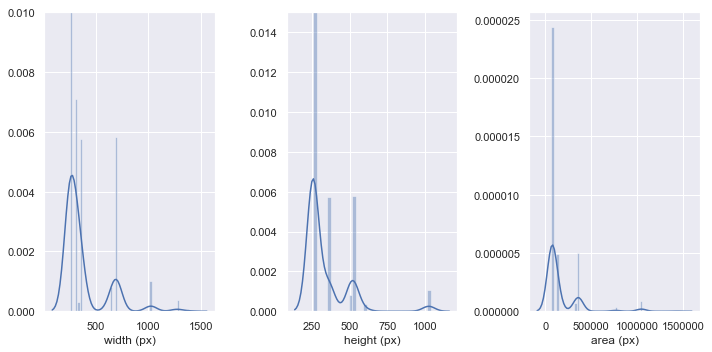

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
width_plt = sns.distplot(df_img['width'].values, ax=ax[0])
width_plt.set(xlabel='width (px)')
width_plt.set(ylim=(0, 0.01))
height_plt = sns.distplot(df_img['height'].values, ax=ax[1])
height_plt.set(xlabel='height (px)')
height_plt.set(ylim=(0, 0.015))
area_plt = sns.distplot(df_img['area'].values)
area_plt.set(xlabel="area (px)")
fig.show()
plt.tight_layout()

The image dimensions do not appear to be equally distributed and have a somewhat bimodal distribution. This issue will need to be addressed before feeding the images to our model. The images could be resized to squares but this will cause images to be squashed either vertically or horizontally and would result in a loss of information. Most of the images look like they are 256x256 so the squashing/stretching might not be an issue. Scaling the smaller images up might be a better option than scaling the larger images down as this would also result in a loss of information. Different strategies should be tried here to see what works best. 

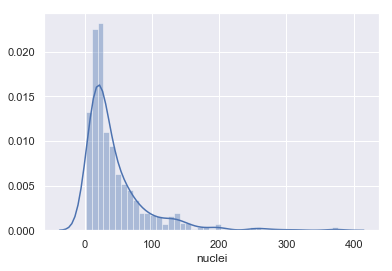

In [15]:
sns.distplot(df_img['nuclei'].values)
plt.xlabel("nuclei")
plt.show()

The distribution of nuclei (masks) per image appears to be skewed to the right. There is quite a large range in the number of nuclei per image. 

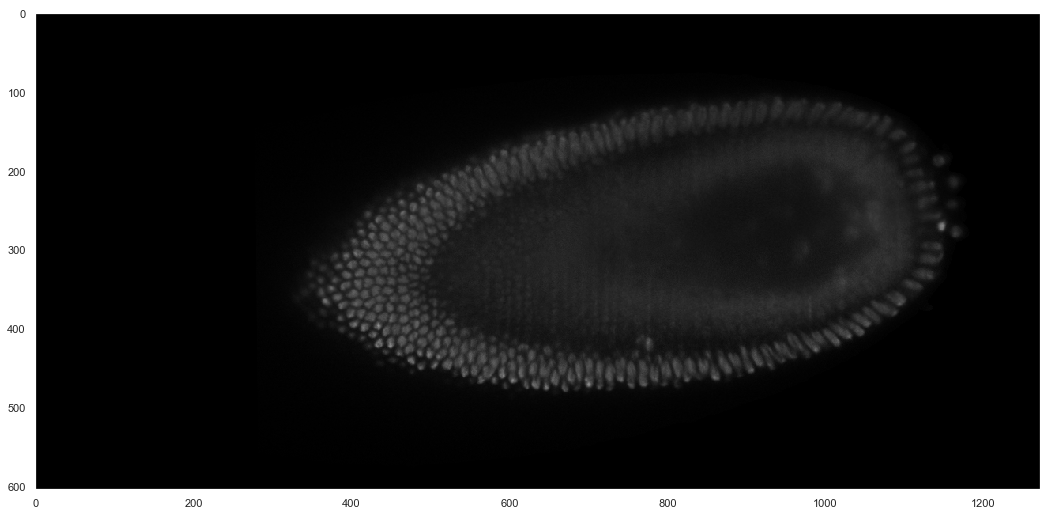

In [19]:
plt.figure(figsize=(18, 18))
much_nuclei = np.argmax(np.array(df_img['nuclei']))
plt.grid(None)
plt.imshow(imgs[much_nuclei])

There are 198 annotated nuclei in this image. It's an interesting structure, possibly some kind of creature!

2


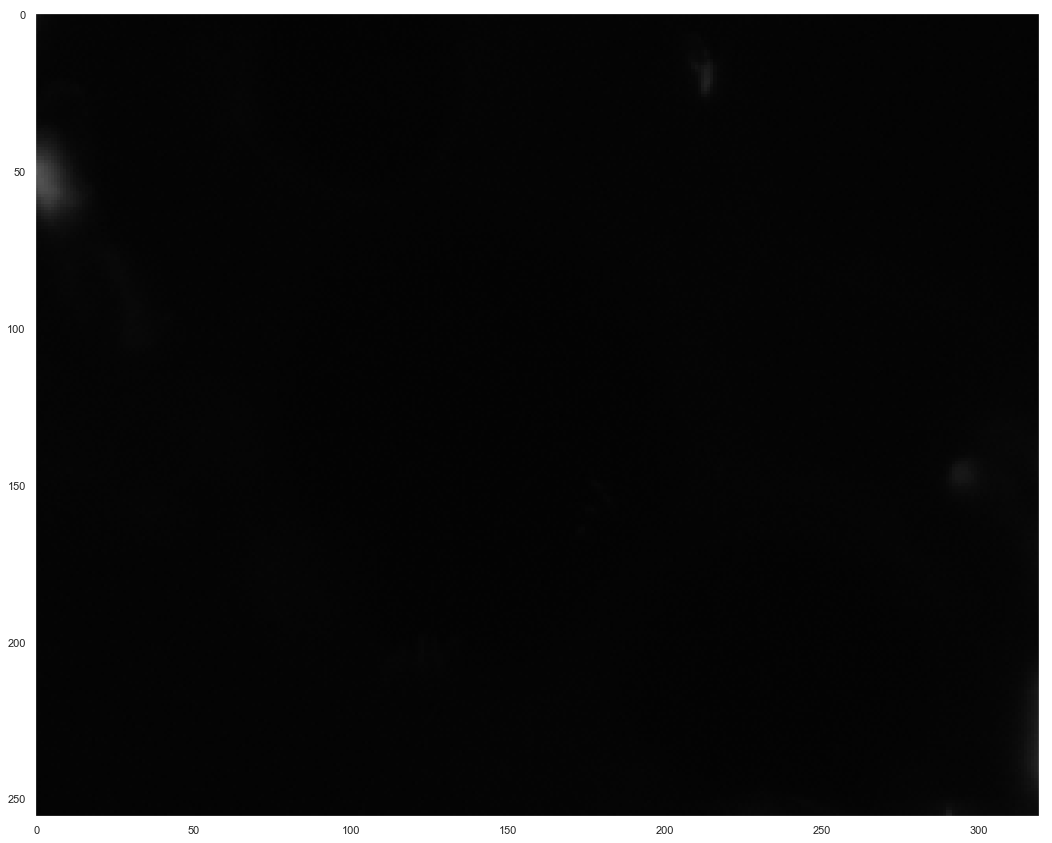

In [20]:
plt.figure(figsize=(18, 18))
not_much_nuclei = np.argmin(np.array(df_img['nuclei']))
print(df_img['nuclei'].min())
plt.grid(None)
plt.imshow(imgs[not_much_nuclei])

**Nuclei Sizes**

Let's take a look at some differently sized nuclei in the training set. 

c:\users\андрей\pycharmprojects\dsb-2018\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


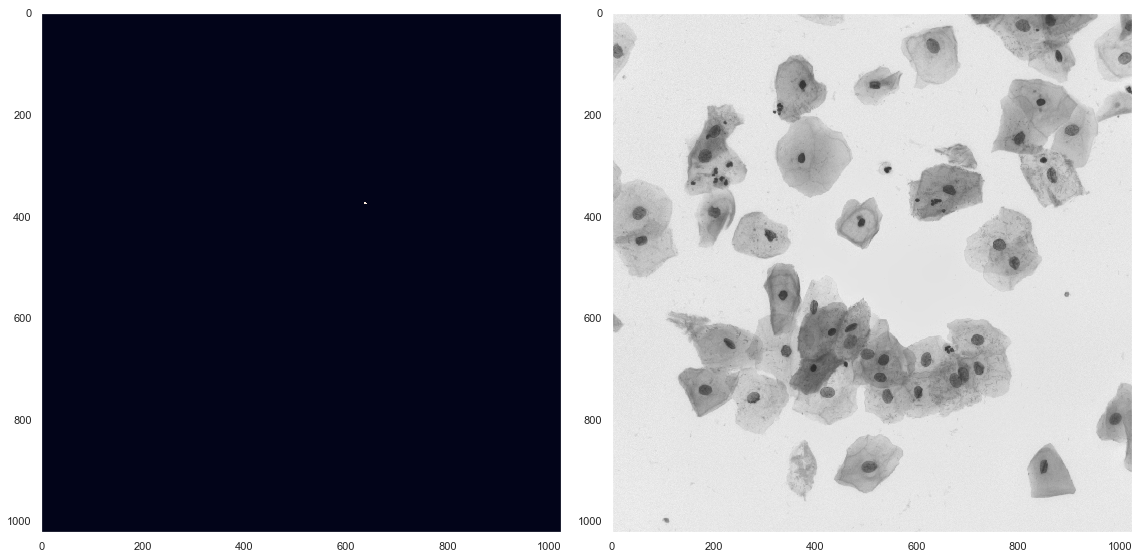

In [21]:
smallest_mask_index = df_mask['mask_to_img_ratio'].argmin()

fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].grid(None)
ax[0].imshow(masks[smallest_mask_index])
ax[1].grid(None)
ax[1].imshow(imgs[df_mask.iloc[[smallest_mask_index], [0]].values[0][0]])
plt.tight_layout()

Wow! This nucleus is either very small or very far away! This makes me concerned about scaling down some of the larger images as some of these small nuclei could become undetectable or a least much more difficult to detect.

0.0
1.5
5.250000000000227


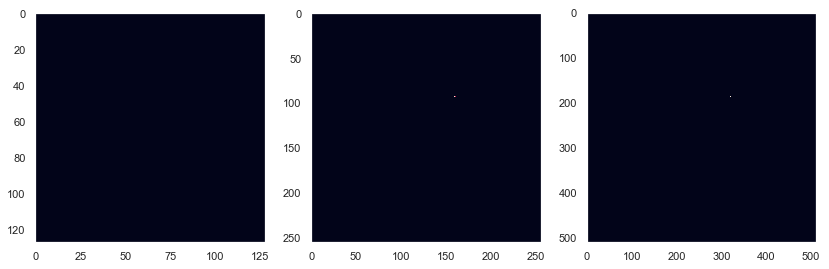

In [22]:
smallest_mask_resized_128 = resize(masks[smallest_mask_index], (128, 128))
smallest_mask_resized_256 = resize(masks[smallest_mask_index], (256, 256))
smallest_mask_resized_512 = resize(masks[smallest_mask_index], (512, 512))
print(np.sum(smallest_mask_resized_128))
print(np.sum(smallest_mask_resized_256))
print(np.sum(smallest_mask_resized_512))
fig, ax = plt.subplots(1, 3, figsize=(14, 14))
ax[0].grid(None)
ax[1].grid(None)
ax[2].grid(None)
ax[0].imshow(smallest_mask_resized_128)
ax[1].imshow(smallest_mask_resized_256)
ax[2].imshow(smallest_mask_resized_512)

As you can see above, the nucleus mask completely disappears when the image is scaled down to 128x128 pixels.